# 1. Managing Analyzers in Azure Content Understanding

<img src="https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/media/overview/content-understanding-framework-2025.png#lightbox">

Azure Content Understanding in Foundry Tools is an Foundry Tool that's available as part of the Microsoft Foundry Resource in the Azure portal. It uses generative AI to process/ingest content of many types (documents, images, videos, and audio) into a user-defined output format. Content Understanding offers a streamlined process to reason over large amounts of unstructured data, accelerating time-to-value by generating an output that can be integrated into automation and analytical workflows.

Content Understanding is now a Generally Available (GA) service with the release of the 2025-11-01 API version. It's now available in a broader range of regions.

### Core Documentation
1. **[What is Azure Content Understanding in Foundry Tools?](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/overview)** - Main overview page
2. **[FAQ - Frequently Asked Questions](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/faq)** - Common questions and answers
3. **[Choosing the Right Tool: Document Intelligence vs Content Understanding](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/choosing-right-ai-tool)** - Comparison guide
4. **[Models and Deployments](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/concepts/models-deployments)** - Supported models configuration
5. **[Pricing Explainer](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/pricing-explainer)** - Pricing details and optimization

### Modality-Specific Documentation
6. **[Document Processing Overview](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/document/overview)** - Field extraction and grounding
7. **[Video Solutions (Preview)](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/video/overview)** - Video analysis capabilities
8. **[Image Solutions (Preview)](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/image/overview)** - Image extraction and analysis
9. **[Face Solutions (Preview)](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/face/overview)** - Face detection and recognition

### Additional Resources
10. **[Transparency Note](https://learn.microsoft.com/en-us/azure/ai-foundry/responsible-ai/content-understanding/transparency-note)** - Responsible AI information
11. **[Code Samples on GitHub](https://github.com/Azure-Samples/azure-ai-content-understanding-python)** - Python implementation examples
12. **[Azure Content Understanding Pricing](https://azure.microsoft.com/pricing/details/content-understanding/)** - Official pricing page

In [1]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import time

from azure.identity import DefaultAzureCredential
from datetime import datetime
from dotenv import load_dotenv
from helper.content_understanding_client import AzureContentUnderstandingClient

In [2]:
sys.version

'3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]'

In [3]:
print(f"Today is {datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 02-Dec-2025 13:21:49


## 1. Client definition

In [4]:
load_dotenv("azure.env")

AZURE_AI_ENDPOINT = os.getenv("AZURE_AI_ENDPOINT")
API_VERSION = "2025-11-01"  # Subject to change. Check the documentation
GPT_4_1_DEPLOYMENT = "gpt-4.1"  # Name of the model deployed in Microsoft Foundry
GPT_4_1_MINI_DEPLOYMENT = "gpt-4.1-mini"  # Name of the model deployed in Microsoft Foundry
TEXT_EMBEDDING_3_LARGE_DEPLOYMENT = "text-embedding-3-large"  # Name of the model deployed in Microsoft Foundry

In [5]:
def token_provider():
    """Provides fresh Azure Cognitive Services tokens."""
    try:
        credential = DefaultAzureCredential()
        token = credential.get_token(
            "https://cognitiveservices.azure.com/.default")
        return token.token
    except Exception as e:
        print(f"❌ Token acquisition failed: {e}")
        raise


try:
    if not AZURE_AI_ENDPOINT or not API_VERSION:
        raise ValueError("AZURE_AI_ENDPOINT and API_VERSION must be set")

    print("Initializing Azure Content Understanding Client...")
    client = AzureContentUnderstandingClient(
        endpoint=AZURE_AI_ENDPOINT,
        api_version=API_VERSION,
        token_provider=token_provider,
        x_ms_useragent="azure-ai-content-understanding-python-sample-ga")
    print("✅ Done")

except ValueError as e:
    print(f"❌ Configuration error: {e}")
    raise
except Exception as e:
    print(f"❌ Client creation failed: {e}")
    raise

Initializing Azure Content Understanding Client...
✅ Done


In [6]:
# Check if required deployments are configured
missing_deployments = []

if not GPT_4_1_DEPLOYMENT:
    missing_deployments.append("GPT_4_1_DEPLOYMENT")
if not GPT_4_1_MINI_DEPLOYMENT:
    missing_deployments.append("GPT_4_1_MINI_DEPLOYMENT")
if not TEXT_EMBEDDING_3_LARGE_DEPLOYMENT:
    missing_deployments.append("TEXT_EMBEDDING_3_LARGE_DEPLOYMENT")

if missing_deployments:
    print(f"❌ Warning: Missing required model deployment configuration(s):")
    for deployment in missing_deployments:
        print(f"   - {deployment}")
    print(
        "\n   Prebuilt analyzers require GPT-4.1, GPT-4.1-mini, and text-embedding-3-large deployments."
    )
    print("   Please:")
    print("   1. Deploy all three models in Azure AI Foundry")
    print("   2. Add the following to notebooks/.env:")
    print("      GPT_4_1_DEPLOYMENT=<your-gpt-4.1-deployment-name>")
    print("      GPT_4_1_MINI_DEPLOYMENT=<your-gpt-4.1-mini-deployment-name>")
    print(
        "      TEXT_EMBEDDING_3_LARGE_DEPLOYMENT=<your-text-embedding-3-large-deployment-name>"
    )
    print("   3. Restart the kernel and run this cell again")

else:
    print(f"📋 Configuring default model deployments...")
    print(f"   GPT-4.1 deployment: {GPT_4_1_DEPLOYMENT}")
    print(f"   GPT-4.1-mini deployment: {GPT_4_1_MINI_DEPLOYMENT}")
    print(
        f"   text-embedding-3-large deployment: {TEXT_EMBEDDING_3_LARGE_DEPLOYMENT}"
    )
    try:
        # Update defaults to map model names to your deployments
        result = client.update_defaults({
            "gpt-4.1":
            GPT_4_1_DEPLOYMENT,
            "gpt-4.1-mini":
            GPT_4_1_MINI_DEPLOYMENT,
            "text-embedding-3-large":
            TEXT_EMBEDDING_3_LARGE_DEPLOYMENT
        })

        print(f"\n✅ Default model deployments configured successfully")
        print(f"   Model mappings:")
        for model, deployment in result.get("modelDeployments", {}).items():
            print(f"     {model} → {deployment}")
    except Exception as e:
        print(f"❌ Failed to configure defaults: {e}")
        print(f"   This may happen if:")
        print(
            f"   - One or more deployment names don't exist in your Azure AI Foundry project"
        )
        print(f"   - You don't have permission to update defaults")
        raise

📋 Configuring default model deployments...
   GPT-4.1 deployment: gpt-4.1
   GPT-4.1-mini deployment: gpt-4.1-mini
   text-embedding-3-large deployment: text-embedding-3-large

✅ Default model deployments configured successfully
   Model mappings:
     gpt-4.1 → gpt-4.1
     gpt-4.1-mini → gpt-4.1-mini
     text-embedding-3-large → text-embedding-3-large


## 2. Get Default Settings

You can retrieve the default model deployment mappings configured for your Content Understanding resource.

In [7]:
try:
    defaults = client.get_defaults()
    print(f"✅ Retrieved default settings")

    model_deployments = defaults.get("modelDeployments", {})

    if model_deployments:
        print(f"\n✅ Model Deployments:")
        for model_name, deployment_name in model_deployments.items():
            print(f"   {model_name}: {deployment_name}")
    else:
        print("❌ No model deployments configured")

except Exception as e:
    print(f"❌  Error retrieving defaults: {e}")
    print("This is expected if no defaults have been configured yet.")

✅ Retrieved default settings

✅ Model Deployments:
   gpt-4.1: gpt-4.1
   gpt-4.1-mini: gpt-4.1-mini
   text-embedding-3-large: text-embedding-3-large


## 3. Create a Simple Analyzer

In [8]:
analyzer_id = f"test_{datetime.today().strftime('%d%b%Y_%H%M%S')}"

print(f"🔧 Creating custom analyzer '{analyzer_id}'...")

call_analyzer = {
    "baseAnalyzerId": "prebuilt-callCenter",
    "description": "test",
    "config": {
        "returnDetails": True,
        "locales": ["en-US"]
    },
    "fieldSchema": {
        "fields": {
            "Summary": {
                "type": "string",
                "method": "generate",
                "description": "A one-paragraph summary"
            },
            "Topics": {
                "type": "array",
                "method": "generate",
                "description": "Top 5 topics mentioned",
                "items": {
                    "type": "string"
                }
            },
            "Companies": {
                "type": "array",
                "method": "generate",
                "description": "List of companies mentioned",
                "items": {
                    "type": "string"
                }
            },
            "People": {
                "type": "array",
                "method": "generate",
                "description": "List of people mentioned",
                "items": {
                    "type": "object",
                    "properties": {
                        "Name": {
                            "type": "string",
                            "description": "Person's name"
                        },
                        "Role": {
                            "type": "string",
                            "description": "Person's title/role"
                        }
                    }
                }
            },
            "Sentiment": {
                "type": "string",
                "method": "classify",
                "description": "Overall sentiment",
                "enum": ["Positive", "Neutral", "Negative"]
            },
            "Categories": {
                "type": "array",
                "method": "classify",
                "description": "List of relevant categories",
                "items": {
                    "type":
                    "string",
                    "enum": [
                        "Agriculture", "Business", "Finance", "Health",
                        "Insurance", "Mining", "Pharmaceutical", "Retail",
                        "Technology", "Transportation"
                    ]
                }
            }
        }
    },
    "models": {
        "completion": "gpt-4.1"
    }
}

response = client.begin_create_analyzer(
    analyzer_id=analyzer_id,
    analyzer_template=call_analyzer,
)

print(f"⏳ Please wait...")
client.poll_result(response)
print(f"✅ Done")

🔧 Creating custom analyzer 'test_02Dec2025_132150'...
⏳ Please wait...
✅ Done


## 4. List All Analyzers in Your Foundry resource

In [9]:
response = client.get_all_analyzers()
analyzers = response.get("value", [])
print(f"✅ Found {len(analyzers)} analyzers")
print("\033[1;31;34m")

for idx, analyzer in enumerate(analyzers, 1):
    print(f"🔍 Analyzer {idx}:")
    print(f"  ID: {analyzer.get('analyzerId')}")
    print(f"  Description: {analyzer.get('description')}")
    print(f"  Status: {analyzer.get('status')}")
    print(f"  Created at: {analyzer.get('createdAt')}")

    if analyzer.get('analyzerId', '').startswith("prebuilt-"):
        print(f"  🔧 Type: Prebuilt analyzer")
    else:
        print(f"  🛠️ Type: Custom analyzer")

    tags = analyzer.get("tags")

    if tags:
        print(f"  🏷️ Tags: {tags}\n")

✅ Found 89 analyzers

🔍 Analyzer 1:
  ID: prebuilt-audio
  Description: Transcribe conversations.
  Status: ready
  Created at: 2025-11-01T00:00:00Z
  🔧 Type: Prebuilt analyzer
🔍 Analyzer 2:
  ID: prebuilt-audioSearch
  Description: Transcribe conversations and extract summaries.
  Status: ready
  Created at: 2025-11-01T00:00:00Z
  🔧 Type: Prebuilt analyzer
🔍 Analyzer 3:
  ID: prebuilt-bankStatement.us
  Description: Extract bank statement US document fields.
  Status: ready
  Created at: 2025-11-01T00:00:00Z
  🔧 Type: Prebuilt analyzer
🔍 Analyzer 4:
  ID: prebuilt-callCenter
  Description: Analyze call center conversations to extract transcripts, summaries, sentiment, and more.
  Status: ready
  Created at: 2025-11-01T00:00:00Z
  🔧 Type: Prebuilt analyzer
🔍 Analyzer 5:
  ID: prebuilt-check.us
  Description: Extract check US document fields.
  Status: ready
  Created at: 2025-11-01T00:00:00Z
  🔧 Type: Prebuilt analyzer
🔍 Analyzer 6:
  ID: prebuilt-contract
  Description: Extract contra

In [10]:
response = client.get_all_analyzers()
analyzers = response.get("value", [])

print(f"✅ Found {len(analyzers)} analyzers")
analyzer_data = []

for analyzer in analyzers:
    analyzer_id = analyzer.get('analyzerId')
    analyzer_type = "Prebuilt analyzer" if analyzer_id and analyzer_id.startswith(
        "prebuilt-") else "Custom analyzer"
    data = {
        'analyzer_id': analyzer_id,
        'description': analyzer.get('description'),
        'status': analyzer.get('status'),
        'created_at': analyzer.get('createdAt'),
        'type': analyzer_type,
        'tags': analyzer.get('tags')
    }
    analyzer_data.append(data)

df = pd.DataFrame(analyzer_data)
df

✅ Found 89 analyzers


,analyzer_id,description,status,created_at,type,tags
0,prebuilt-audio,Transcribe conversations.,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
1,prebuilt-audioSearch,Transcribe conversations and extract summaries.,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
2,prebuilt-bankStatement.us,Extract bank statement US document fields.,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
3,prebuilt-callCenter,Analyze call center conversations to extract t...,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
4,prebuilt-check.us,Extract check US document fields.,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
...,...,...,...,...,...,...
84,prebuilt-video,Analyze videos to extract transcript and descr...,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
85,prebuilt-videoSearch,Analyze videos to extract transcript and descr...,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
86,prebuilt-videoSynopsis,Analyze video segment to extract transcripts a...,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
87,custom_analyzer_01Dec2025_172009,Sample invoice analyzer that extracts vendor i...,ready,2025-12-01T17:20:10Z,Custom analyzer,None


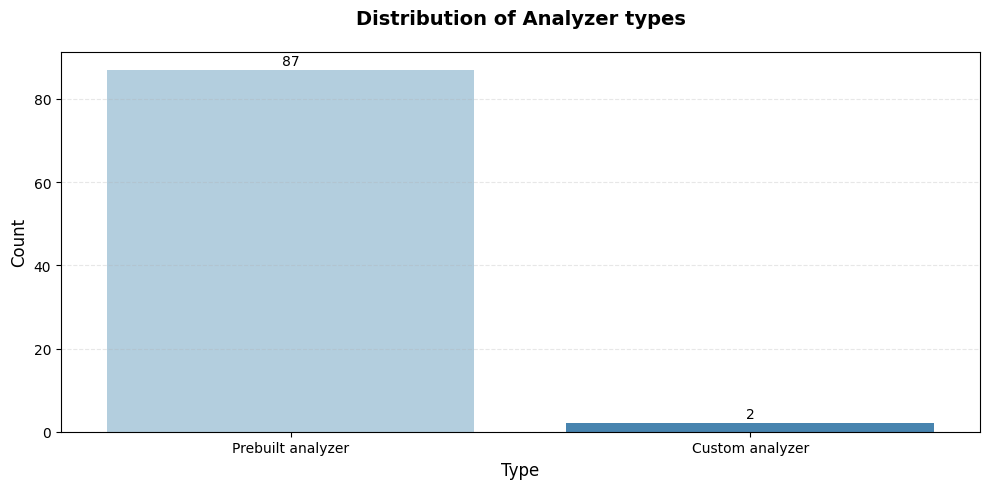

In [11]:
counts = df['type'].value_counts(sort=True)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=counts.index,
                 y=counts.values,
                 hue=counts.index,
                 palette='Blues',
                 legend=False)

for i, v in enumerate(counts.values):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Analyzer types',
          fontsize=14,
          fontweight='bold',
          pad=20)
plt.xlabel('Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [12]:
pb_df = df[df['type'] == 'Prebuilt analyzer']
pb_df

,analyzer_id,description,status,created_at,type,tags
0,prebuilt-audio,Transcribe conversations.,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
1,prebuilt-audioSearch,Transcribe conversations and extract summaries.,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
2,prebuilt-bankStatement.us,Extract bank statement US document fields.,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
3,prebuilt-callCenter,Analyze call center conversations to extract t...,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
4,prebuilt-check.us,Extract check US document fields.,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
...,...,...,...,...,...,...
82,prebuilt-tax.us.w4,Extract tax US w4 document fields.,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
83,prebuilt-utilityBill,Extract utility bill document fields.,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
84,prebuilt-video,Analyze videos to extract transcript and descr...,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
85,prebuilt-videoSearch,Analyze videos to extract transcript and descr...,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None


In [13]:
custom_df = df[df['type'] == 'Custom analyzer']
custom_df

,analyzer_id,description,status,created_at,type,tags
87,custom_analyzer_01Dec2025_172009,Sample invoice analyzer that extracts vendor i...,ready,2025-12-01T17:20:10Z,Custom analyzer,None
88,test_02Dec2025_132150,test,ready,2025-12-02T13:21:51Z,Custom analyzer,None


## 5. Get Analyzer Details by ID

Keep track of the analyzer ID when you create it. Use the ID to retrieve detailed analyzer definitions later.

In [14]:
retrieved_analyzer = client.get_analyzer_detail_by_id(analyzer_id=analyzer_id)

print(f"✅ Analyzer '{analyzer_id}' retrieved successfully! \n")
print(f" Description: {retrieved_analyzer.get('description')}")
print(f" Status: {retrieved_analyzer.get('status')}")
print(f" Created at: {retrieved_analyzer.get('createdAt')}")

✅ Analyzer 'test_02Dec2025_132150' retrieved successfully! 

 Description: test
 Status: ready
 Created at: 2025-12-02T13:21:51Z


In [15]:
print("📄 Full Analyzer Details:")
print("\033[1;31;34m")
print(json.dumps(retrieved_analyzer, indent=5))

📄 Full Analyzer Details:

{
     "analyzerId": "test_02Dec2025_132150",
     "description": "test",
     "createdAt": "2025-12-02T13:21:51Z",
     "lastModifiedAt": "2025-12-02T13:21:51Z",
     "baseAnalyzerId": "prebuilt-callCenter",
     "config": {
          "locales": [
               "en-US"
          ],
          "returnDetails": true
     },
     "fieldSchema": {
          "fields": {
               "Summary": {
                    "type": "string",
                    "method": "generate",
                    "description": "A one-paragraph summary"
               },
               "Topics": {
                    "type": "array",
                    "method": "generate",
                    "description": "Top 5 topics mentioned",
                    "items": {
                         "type": "string"
                    }
               },
               "Companies": {
                    "type": "array",
                    "method": "generate",
                    "descript

## 6. Delete an Analyzer
If you no longer need an analyzer, delete it using its ID.

In [16]:
print(f"🗑️ Deleting classifier '{analyzer_id}'...")
client.delete_analyzer(analyzer_id=analyzer_id)
print(f"✅ Done")

🗑️ Deleting classifier 'test_02Dec2025_132150'...
✅ Done


In [17]:
response = client.get_all_analyzers()

analyzers = response.get("value", [])
print(f"✅ Found {len(analyzers)} analyzers")

analyzer_data = []

for analyzer in analyzers:
    analyzer_id = analyzer.get('analyzerId')
    analyzer_type = "Prebuilt analyzer" if analyzer_id and analyzer_id.startswith(
        "prebuilt-") else "Custom analyzer"
    data = {
        'analyzer_id': analyzer_id,
        'description': analyzer.get('description'),
        'status': analyzer.get('status'),
        'created_at': analyzer.get('createdAt'),
        'type': analyzer_type,
        'tags': analyzer.get('tags')
    }
    analyzer_data.append(data)

df = pd.DataFrame(analyzer_data)
df

✅ Found 88 analyzers


,analyzer_id,description,status,created_at,type,tags
0,prebuilt-audio,Transcribe conversations.,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
1,prebuilt-audioSearch,Transcribe conversations and extract summaries.,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
2,prebuilt-bankStatement.us,Extract bank statement US document fields.,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
3,prebuilt-callCenter,Analyze call center conversations to extract t...,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
4,prebuilt-check.us,Extract check US document fields.,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
...,...,...,...,...,...,...
83,prebuilt-utilityBill,Extract utility bill document fields.,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
84,prebuilt-video,Analyze videos to extract transcript and descr...,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
85,prebuilt-videoSearch,Analyze videos to extract transcript and descr...,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None
86,prebuilt-videoSynopsis,Analyze video segment to extract transcripts a...,ready,2025-11-01T00:00:00Z,Prebuilt analyzer,None


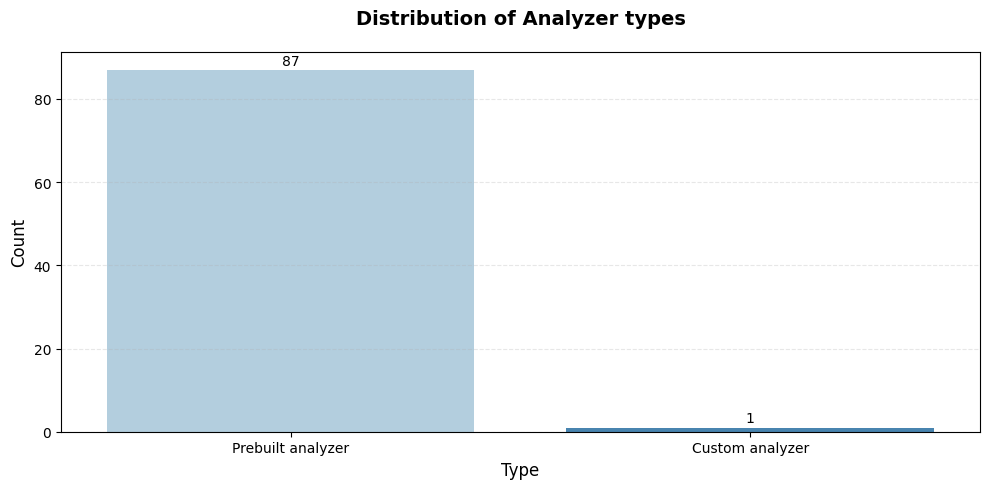

In [18]:
counts = df['type'].value_counts(sort=True)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=counts.index,
                 y=counts.values,
                 hue=counts.index,
                 palette='Blues',
                 legend=False)

for i, v in enumerate(counts.values):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Analyzer types',
          fontsize=14,
          fontweight='bold',
          pad=20)
plt.xlabel('Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

> The custom analyzer was deleted